#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 13
**CH11 Used cars**

using the used-cars dataset

version 0.8 2021-07-15

In [62]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from mizani.formatters import percent_format
from plotnine import *
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import KFold
from math import sqrt
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
# turning off scientific notation
#pd.set_option("display.float_format", lambda x: "%.2f" % x)


In [63]:
# DATA IMPORT
data = pd.read_csv("/workspaces/codespaces-jupyter/data/used-cars_2cities_prep.csv")

In [64]:
# SAMPLE DESIGN

# Manage missing
data["fuel"] = data["fuel"].fillna("Missing")
data["condition"] = data["condition"].fillna("Missing")
data["drive"] = data["drive"].fillna("Missing")
data["cylinders"] = data["cylinders"].fillna("Missing")
data["transmission"] = data["transmission"].fillna("Missing")
data["type"] = data["type"].fillna("Missing")

# drop hybrid models then drop column
data = data.loc[data.Hybrid == 0].drop(["Hybrid"], axis=1)


In [65]:
# check frequency by fuel type
freq = data.groupby("fuel").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq


,frequency,percent,cumulative_percent
fuel,,,
Missing,1,0.190,0.190
diesel,1,0.190,0.380
gas,516,98.099,98.479
hybrid,1,0.190,98.669
other,7,1.331,100.000


In [66]:
# keep gas-fuelled vehicles
data = data.loc[data.fuel == "gas"]
# check frequency by vehicle condition
freq = data.groupby("condition").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq


,frequency,percent,cumulative_percent
condition,,,
Missing,207,40.116,40.116
excellent,133,25.775,65.891
fair,14,2.713,68.604
good,106,20.543,89.147
like new,53,10.271,99.418
new,3,0.581,99.999


In [67]:
# drop vehicles in fair and new condition, trucks
data = data.loc[~data.condition.isin(["new", "fair"])]

# drop unrealistic values for price and odometer reading
data = data.loc[(data.price >= 500) & (data.price <= 25000) & (data.odometer <= 100)]

# drop if price is smaller than 1000 and condition is like new or age is less than 8
data = data.loc[
    ~((data.price < 1000) & ((data.condition == "like new") | (data.age < 8)))
]

In [68]:
# check frequency by transmission
freq = data.groupby("transmission").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq

,frequency,percent,cumulative_percent
transmission,,,
automatic,478,98.557,98.557
manual,7,1.443,100.000


In [69]:
data = data.loc[~(data.transmission == "manual")]

In [70]:
# check frequency by transmission
freq = data.groupby("type").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq


,frequency,percent,cumulative_percent
type,,,
Missing,223,46.653,46.653
SUV,1,0.209,46.862
convertible,6,1.255,48.117
coupe,19,3.975,52.092
pickup,1,0.209,52.301
sedan,227,47.490,99.791
wagon,1,0.209,100.000


In [71]:
# drop if truck
data = data.loc[~(data.type == "truck")]
# drop pricestr
data = data.drop(["pricestr"], axis=1)

In [72]:
# DATA GENERATION & DESCRIPTIVES
# CONDITION
data["cond_excellent"] = np.where(data["condition"] == "excellent", 1, 0)
data["cond_good"] = np.where(data["condition"] == "good", 1, 0)
data["cond_likenew"] = np.where(data["condition"] == "like new", 1, 0)
# cylinders
data["cylind6"] = np.where(data["cylinders"] == "6 cylinders", 1, 0)
data.cylinders.value_counts()
data.cylind6.value_counts()
# age: quadratic, cubic
data["agesq"] = data["age"] ** 2
data["agecu"] = data["age"] ** 3
# odometer quadratic
data["odometersq"] = data["odometer"] ** 2


In [73]:
# Frequency tables
# area
data.groupby("area").agg(frequency=("price", "size"), mean=("price", np.mean))

,frequency,mean
area,,
chicago,281,6060.975089
los angeles,197,5518.253807


In [74]:
# focus only on Chicago
data = data.loc[data.area == "chicago"]

In [75]:
# condition
data.groupby("condition").agg(frequency=("price", "size"), mean=("price", np.mean))

,frequency,mean
condition,,
Missing,124,6611.161290
excellent,75,6724.186667
good,67,3988.179104
like new,15,7455.200000


In [76]:
# drive
data.groupby("drive").agg(frequency=("price", "size"), mean=("price", np.mean))

,frequency,mean
drive,,
4wd,4,10168.750000
Missing,106,4575.094340
fwd,169,6893.485207
rwd,2,6250.000000


In [77]:
# dealer
data.groupby("dealer").agg(frequency=("price", "size"), mean=("price", np.mean))

,frequency,mean
dealer,,
0,193,4402.181347
1,88,9699.011364


In [78]:
# data summary
data.loc[
    :,
    [
        "age",
        "odometer",
        "LE",
        "XLE",
        "SE",
        "cond_likenew",
        "cond_excellent",
        "cond_good",
        "cylind6",
    ],
].describe()


,age,odometer,LE,XLE,SE,cond_likenew,cond_excellent,cond_good,cylind6
count,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000
mean,12.298932,12.521702,0.192171,0.071174,0.064057,0.053381,0.266904,0.238434,0.145907
std,5.892153,5.172572,0.394710,0.257575,0.245291,0.225193,0.443131,0.426886,0.353643
min,1.000000,0.231900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,8.140000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13.000000,13.655900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,17.000000,16.430000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,27.000000,25.300000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Linear regressions

In [79]:
# Model 1: Linear regression on age
model1 = "price ~ age + agesq"

# Models 2-5: Multiple linear regressions
# note: condition - missing will be baseline for regs
model2 = "price ~ age + agesq + odometer"
model3 = "price ~ age + agesq + odometer + odometersq + LE + cond_excellent + cond_good + dealer"
model4 = "price ~ age + agesq + odometer + odometersq + LE + XLE + SE + cond_likenew + cond_excellent + cond_good + cylind6 + dealer"
model5 = "price ~ age + agesq + odometer + odometersq + LE * age + XLE * age + SE * age + cond_likenew * age + cond_excellent * age + cond_good * age + cylind6 * age + odometer * age + dealer * age"

model_equations = [model1, model2, model3, model4, model5]

In [80]:
# Matrix form

X1 = data[['age', 'agesq']]  
y2 = data['price']          

model1 = LinearRegression()
model1.fit(X1, y2)
print(model1.coef_, model1.intercept_)

[-1530.08828422    35.0482224 ] 18365.447142801124


Estimate ALL regressions

In [81]:
regs = []
for equation in model_equations:
    regs.append(smf.ols(equation, data).fit(cov_type="HC1"))

### Table 13.2 Regression models for predicting used car price

In [82]:
stargazer.Stargazer(regs[:5])

In [83]:
# not using startgazer

import statsmodels.formula.api as smf

results = [smf.ols(eq, data=data).fit() for eq in model_equations]

for i, res in enumerate(results, 1):
    print(f"\nModel {i} Summary:")
    print(res.summary())


Model 1 Summary:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     767.7
Date:                Tue, 29 Jul 2025   Prob (F-statistic):          6.17e-114
Time:                        02:30:42   Log-Likelihood:                -2497.9
No. Observations:                 281   AIC:                             5002.
Df Residuals:                     278   BIC:                             5013.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.837e+04    407.859  

## Cross validation

Use custom function `ols_crossvalidator` for cross validation

I run sklearn library

Set n_fold = 4 for 4-fold cross-validation

Cross-validate models

In [84]:
# for model2: model2 = "price ~ age + agesq + odometer"
# Define predictors and target
X = data[["age", "agesq", "odometer"]]  
y = data["price"]                       

# 2. Set up KFold  with 5. folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list = []

# 3. Loop through each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = sqrt(mean_squared_error(y_test, y_pred))
    rmse_list.append(rmse)

# 4. Average RMSE
average_rmse = np.mean(rmse_list)

print("RMSEs for each fold:", rmse_list)
print("Average RMSE:", average_rmse)

RMSEs for each fold: [1649.78461830922, 1638.748453505182, 1325.5233013689963, 1276.5842377501262, 1441.4061811610047]
Average RMSE: 1466.4093584189056


In [85]:
k_fold = 8

In [86]:
model1 = "price ~ age + agesq"
model2 = "price ~ age + agesq + odometer"
model3 = "price ~ age + agesq + odometer + odometersq + LE + cond_excellent + cond_good + dealer"
model4 = "price ~ age + agesq + odometer + odometersq + LE + XLE + SE + cond_likenew + cond_excellent + cond_good + cylind6 + dealer"
model5 = "price ~ age + agesq + odometer + odometersq + LE * age + XLE * age + SE * age + cond_likenew * age + cond_excellent * age + cond_good * age + cylind6 * age + odometer * age + dealer * age"

model_equations = [model1, model2, model3, model4, model5]

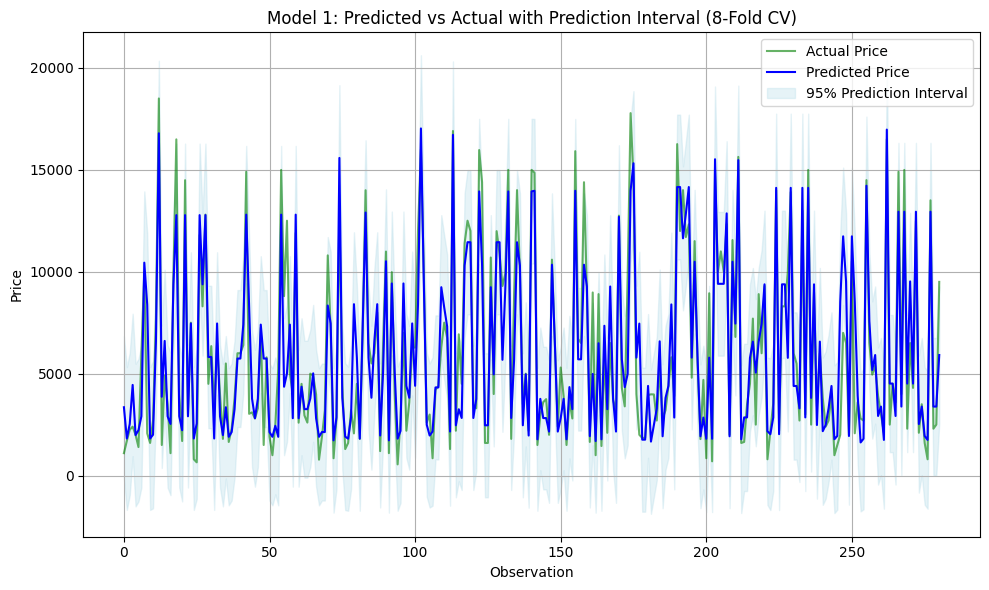

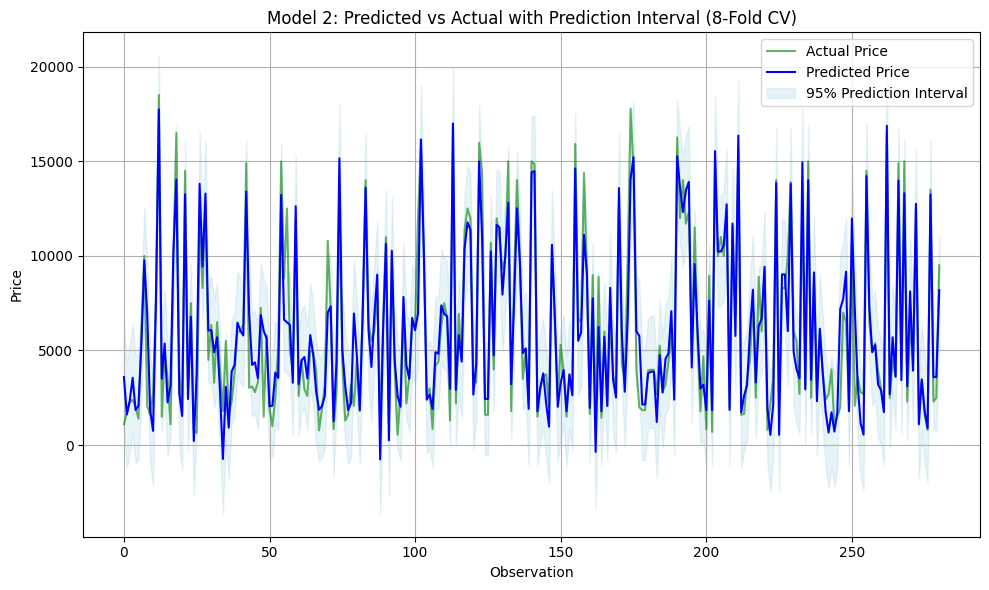

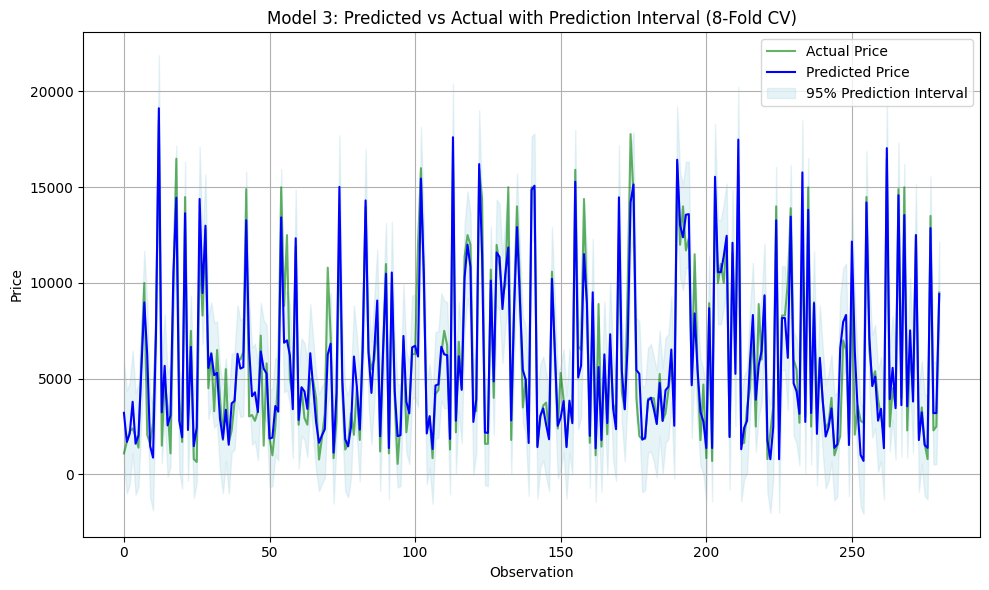

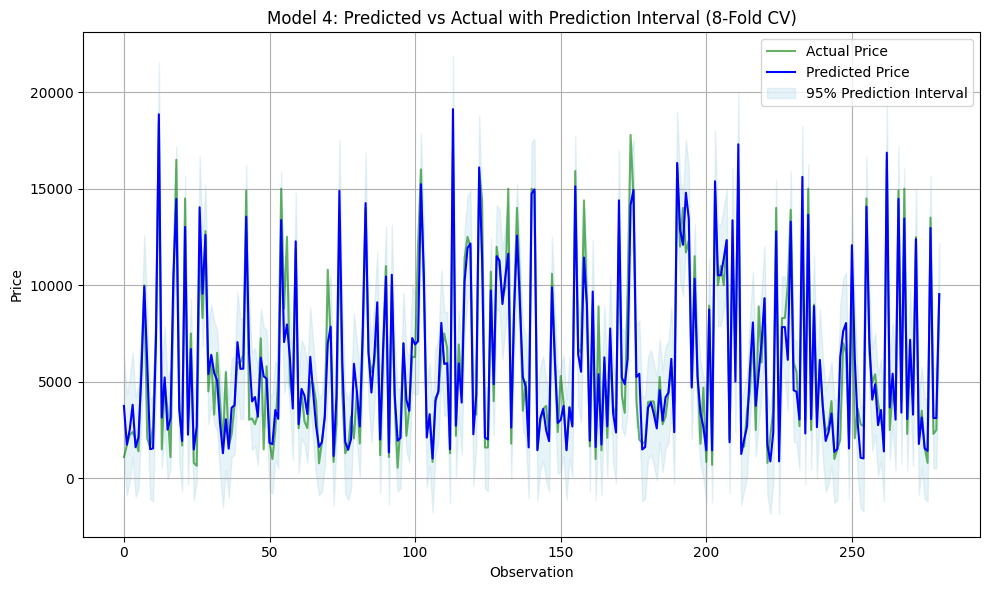

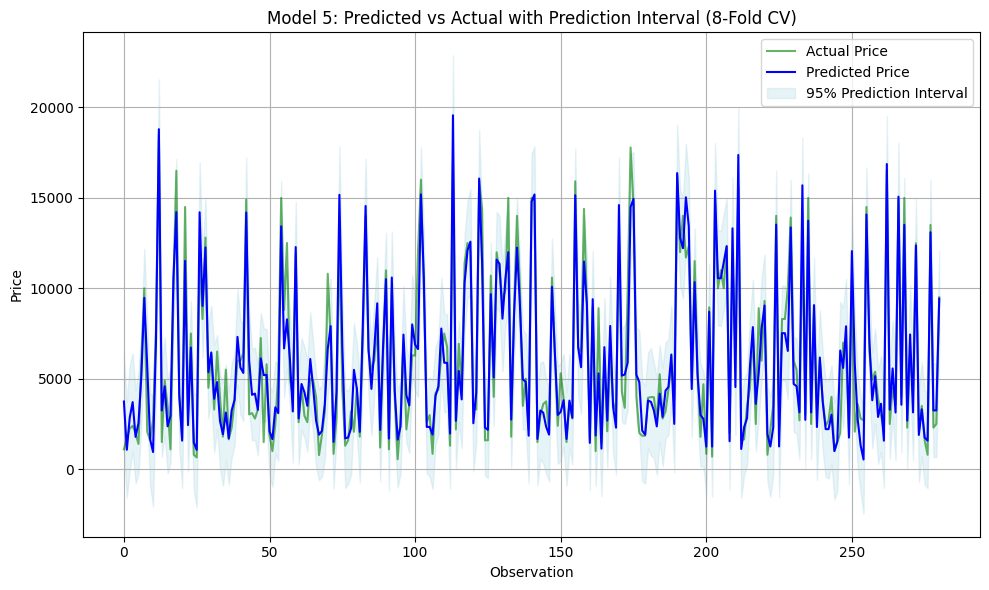

In [151]:
model_equations = [
    "price ~ age + agesq",
    "price ~ age + agesq + odometer",
    "price ~ age + agesq + odometer + odometersq + LE + cond_excellent + cond_good + dealer",
    "price ~ age + agesq + odometer + odometersq + LE + XLE + SE + cond_likenew + cond_excellent + cond_good + cylind6 + dealer",
    "price ~ age + agesq + odometer + odometersq + LE * age + XLE * age + SE * age + cond_likenew * age + cond_excellent * age + cond_good * age + cylind6 * age + odometer * age + dealer * age"
]
# Prepare KFold
kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)
results_tables = []


# Loop through models
for i, formula in enumerate(model_equations):
    preds = []
    lowers = []
    uppers = []
    actuals = []
    diff = []

    for train_idx, test_idx in kf.split(data):
        train_data = data.iloc[train_idx]
        test_data = data.iloc[test_idx]
        
        model = smf.ols(formula, data=train_data).fit()
        pred_result = model.get_prediction(test_data)
        summary_frame = pred_result.summary_frame(alpha=0.05)  # 95% interval
        
        preds.extend(summary_frame['mean'])
        lowers.extend(summary_frame['obs_ci_lower'])
        uppers.extend(summary_frame['obs_ci_upper'])
        actuals.extend(test_data['price'])
        diff.extend(test_data['price'] - summary_frame['mean'])

    # Plot for this model
    plt.figure(figsize=(10, 6))
    plt.plot(actuals, label='Actual Price', color = 'green', alpha=0.6)
    plt.plot(preds, label='Predicted Price', color='blue')
    plt.fill_between(range(len(preds)), lowers, uppers, color='lightblue', alpha=0.3, label='95% Prediction Interval')
    plt.title(f'Model {i+1}: Predicted vs Actual with Prediction Interval ({k_fold}-Fold CV)')
    plt.xlabel("Observation")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    for train_idx, test_idx in kf.split(data):
        train_data = data.iloc[train_idx]
        test_data = data.iloc[test_idx]    
        plt.show()

### Test Set with Predicitions ,Actuals, Diffs and CI Intervals

In [152]:
tables = []
for i, formula in enumerate(model_equations):
    # Fit the model on the whole data (or use your CV split as needed)
    model = smf.ols(formula, data=data).fit()
    pred_result = model.get_prediction(data)
    summary_frame = pred_result.summary_frame(alpha=0.05)
    
    table = pd.DataFrame({
        "Model Name": [f"Model {i+1}"] * len(data),
        "Actual": data["price"].values,
        "Predicted": summary_frame["mean"].values,
        "Diffs": data["price"].values - summary_frame["mean"].values,
        "Lower Bound": summary_frame["obs_ci_lower"].values,
        "Upper Bound": summary_frame["obs_ci_upper"].values,
    })
    table.reset_index(drop=True, inplace=True)
    tables.append(table)

# Display all tables
for table in tables:
    display(table)

,Model Name,Actual,Predicted,Diffs,Lower Bound,Upper Bound
0,Model 1,14850,14090.616292,759.383708,10583.426398,17597.806186
1,Model 1,15630,15445.463464,184.536536,11924.354838,18966.572089
2,Model 1,850,2018.379038,-1168.379038,-1555.681064,5592.439140
3,Model 1,1600,1782.970419,-182.970419,-1709.886772,5275.827610
4,Model 1,1500,1782.970419,-282.970419,-1709.886772,5275.827610
...,...,...,...,...,...,...
276,Model 1,17777,14090.616292,3686.383708,10583.426398,17597.806186
277,Model 1,14593,15445.463464,-852.463464,11924.354838,18966.572089
278,Model 1,5499,3299.972920,2199.027080,-184.477978,6784.423818
279,Model 1,10800,8367.827103,2432.172897,4883.598734,11852.055471


,Model Name,Actual,Predicted,Diffs,Lower Bound,Upper Bound
0,Model 2,14850,14576.058826,273.941174,11704.855221,17447.262431
1,Model 2,15630,16272.752754,-642.752754,13387.980792,19157.524717
2,Model 2,850,1731.180329,-881.180329,-1193.989527,4656.350186
3,Model 2,1600,1825.204629,-225.204629,-1033.127356,4683.536614
4,Model 2,1500,1825.204629,-325.204629,-1033.127356,4683.536614
...,...,...,...,...,...,...
276,Model 2,17777,14153.382369,3623.617631,11283.310948,17023.453790
277,Model 2,14593,15290.375656,-697.375656,12408.816240,18171.935071
278,Model 2,5499,3073.568989,2425.431011,221.872780,5925.265197
279,Model 2,10800,6980.711506,3819.288494,4119.999995,9841.423017


,Model Name,Actual,Predicted,Diffs,Lower Bound,Upper Bound
0,Model 3,14850,15178.975337,-328.975337,12488.193934,17869.756740
1,Model 3,15630,17337.585000,-1707.585000,14626.548795,20048.621204
2,Model 3,850,1265.050905,-415.050905,-1475.162814,4005.264624
3,Model 3,1600,1478.668362,121.331638,-1212.257175,4169.593898
4,Model 3,1500,1450.555535,49.444465,-1219.885786,4120.996855
...,...,...,...,...,...,...
276,Model 3,17777,14317.372184,3459.627816,11628.848255,17005.896112
277,Model 3,14593,15172.592228,-579.592228,12486.653465,17858.530990
278,Model 3,5499,3392.549217,2106.450783,708.290788,6076.807646
279,Model 3,10800,6217.781643,4582.218357,3540.826021,8894.737266


,Model Name,Actual,Predicted,Diffs,Lower Bound,Upper Bound
0,Model 4,14850,15052.823708,-202.823708,12439.541670,17666.105746
1,Model 4,15630,17179.149169,-1549.149169,14546.526453,19811.771884
2,Model 4,850,982.996789,-132.996789,-1697.755145,3663.748724
3,Model 4,1600,1427.615675,172.384325,-1186.123598,4041.354949
4,Model 4,1500,1448.097216,51.902784,-1144.801441,4040.995873
...,...,...,...,...,...,...
276,Model 4,17777,14485.314509,3291.685491,11814.960544,17155.668473
277,Model 4,14593,14993.125292,-400.125292,12385.808944,17600.441641
278,Model 4,5499,3183.008668,2315.991332,552.192264,5813.825073
279,Model 4,10800,7300.547251,3499.452749,4638.696507,9962.397994


,Model Name,Actual,Predicted,Diffs,Lower Bound,Upper Bound
0,Model 5,14850,15190.761056,-340.761056,12550.599394,17830.922719
1,Model 5,15630,17226.178142,-1596.178142,14603.205774,19849.150511
2,Model 5,850,1614.101222,-764.101222,-1165.168218,4393.370662
3,Model 5,1600,1237.192594,362.807406,-1414.046668,3888.431856
4,Model 5,1500,1676.204877,-176.204877,-909.022241,4261.431994
...,...,...,...,...,...,...
276,Model 5,17777,15039.252589,2737.747411,12199.987464,17878.517715
277,Model 5,14593,15021.120559,-428.120559,12422.106675,17620.134443
278,Model 5,5499,3323.281523,2175.718477,691.403151,5955.159895
279,Model 5,10800,6951.723632,3848.276368,4295.866307,9607.580957


In [153]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

metrics = []
for i, formula in enumerate(model_equations):
    model = smf.ols(formula, data=data).fit()
    y_true = data["price"]
    y_pred = model.fittedvalues

    r2 = r2_score(y_true, y_pred)
    bic = model.bic
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    metrics.append({
        "Model": f"Model {i+1}",
        "R2": r2,
        "BIC": bic,
        "RMSE": rmse,
        "MAE": mae
    })

metrics_df = pd.DataFrame(metrics)
display(metrics_df)

,Model,R2,BIC,RMSE,MAE
0,Model 1,0.846700,5012.682481,1755.181120,1204.120500
1,Model 2,0.897712,4904.626831,1433.715829,1013.390321
2,Model 3,0.912944,4887.511250,1322.668765,910.824553
3,Model 4,0.919277,4888.842112,1273.652721,915.648812
4,Model 5,0.923323,4925.137165,1241.321999,902.222296


In [156]:
#R2 evaluation
metrics_df.nlargest(2, 'R2')

,Model,R2,BIC,RMSE,MAE
4,Model 5,0.923323,4925.137165,1241.321999,902.222296
3,Model 4,0.919277,4888.842112,1273.652721,915.648812


In [157]:
#BIC evaluation
metrics_df.nsmallest(2, 'BIC')

,Model,R2,BIC,RMSE,MAE
2,Model 3,0.912944,4887.511250,1322.668765,910.824553
3,Model 4,0.919277,4888.842112,1273.652721,915.648812


In [162]:
#RMSE evaluation
metrics_df.nsmallest(2, 'RMSE')

,Model,R2,BIC,RMSE,MAE
4,Model 5,0.923323,4925.137165,1241.321999,902.222296
3,Model 4,0.919277,4888.842112,1273.652721,915.648812


In [163]:
#MAE evaluation (CV)
metrics_df.nsmallest(2, 'MAE')

,Model,R2,BIC,RMSE,MAE
4,Model 5,0.923323,4925.137165,1241.321999,902.222296
2,Model 3,0.912944,4887.511250,1322.668765,910.824553


In [90]:
# for all models and using k fold = 10

def ols_crossvalidator(equation, data, n_fold=k_fold, average_rmse=False):
    kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)
    rmse_list = []

    for train_index, test_index in kf.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        model = smf.ols(equation, data=train_data).fit()
        y_pred = model.predict(test_data)
        y_true = test_data[equation.split("~")[0].strip()]

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        rmse_list.append(rmse)

    if average_rmse:
        return np.mean(rmse_list)
    else:
        return rmse_list

cv_list = []
for equation in model_equations:
    result = ols_crossvalidator(equation, data, n_fold=k_fold, average_rmse=False)
    cv_list.append(result)
cv_list


[[np.float64(1757.33930701584),
  np.float64(2174.286815061449),
  np.float64(1630.1841204625018),
  np.float64(1625.6557182051922),
  np.float64(1749.7117567835446),
  np.float64(1640.8318034708147),
  np.float64(1249.5092850328094),
  np.float64(2177.439653236588)],
 [np.float64(1602.572796374926),
  np.float64(1862.6534746192776),
  np.float64(1522.2447513917848),
  np.float64(1084.5262832187655),
  np.float64(1357.621384052129),
  np.float64(1237.1165685859924),
  np.float64(1292.0746955915215),
  np.float64(1572.1906233779973)],
 [np.float64(1394.1722466631702),
  np.float64(1778.1437898601293),
  np.float64(1420.3170056848753),
  np.float64(1020.3699493403248),
  np.float64(1299.0203041433804),
  np.float64(1167.083881850147),
  np.float64(1270.483587808249),
  np.float64(1396.25448115234)],
 [np.float64(1390.817175818098),
  np.float64(1612.7204692218104),
  np.float64(1351.7089356448744),
  np.float64(1163.652370907822),
  np.float64(1374.869455061391),
  np.float64(1208.681227

### Table 13.5 Car price models estimated and evaluated using 4-fold cross-validation and RMSE

In [91]:
pd.DataFrame(
    cv_list,
    index=["Model " + str(i + 1) for i in range(len(cv_list))],
    columns=["Fold" + str(i + 1) for i in range(len(cv_list[0]))],
).assign(Average=lambda x: x.mean(axis=1)).T.round().astype(int)

,Model 1,Model 2,Model 3,Model 4,Model 5
Fold1,1757,1603,1394,1391,1402
Fold2,2174,1863,1778,1613,1592
Fold3,1630,1522,1420,1352,1432
Fold4,1626,1085,1020,1164,1198
Fold5,1750,1358,1299,1375,1404
Fold6,1641,1237,1167,1209,1187
Fold7,1250,1292,1270,1273,1261
Fold8,2177,1572,1396,1312,1328
Average,1751,1441,1343,1336,1350


## Plots to visualize the diff between k_folds=4 and k_folds=10

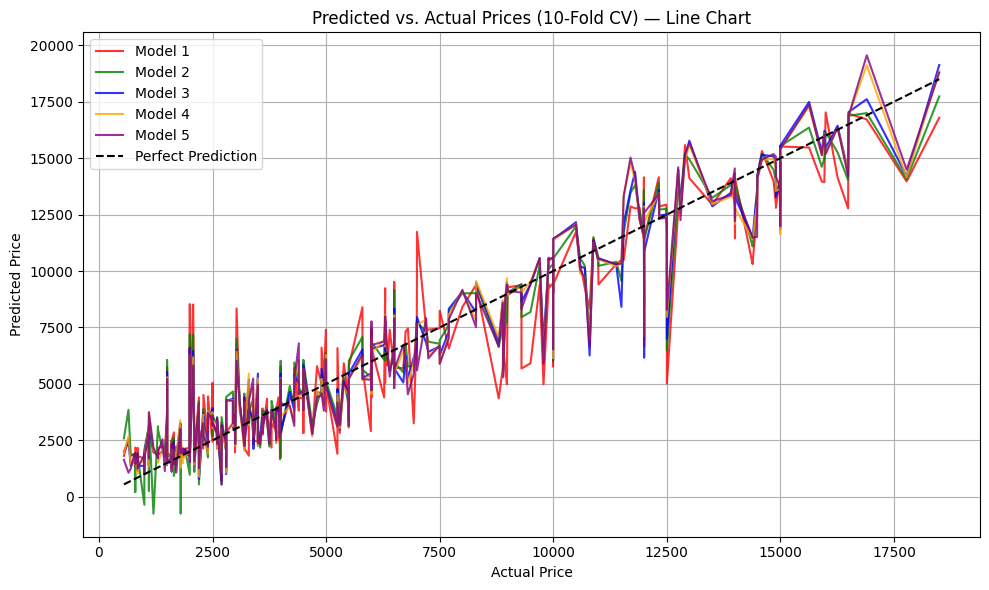

In [92]:
results = []
kf1 = KFold(n_splits=k_fold, shuffle=True, random_state=42)

for formula in model_equations:
    preds = []
    actuals = []
    for train_idx, test_idx in kf.split(data):
        train_data = data.iloc[train_idx]
        test_data = data.iloc[test_idx]
        model = smf.ols(formula, data=train_data).fit()
        y_pred = model.predict(test_data)
        preds.extend(y_pred)
        actuals.extend(test_data['price'])
    results.append((np.array(actuals), np.array(preds)))

# Sort by actual price to align line charts
sorted_indices = np.argsort(results[0][0])  # use actuals from model 1 for consistent sorting
sorted_actual = results[0][0][sorted_indices]

# Plot
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue', 'orange', 'purple']

for i, (actual, pred) in enumerate(results):
    sorted_pred = pred[sorted_indices]
    plt.plot(sorted_actual, sorted_pred, label=f'Model {i+1}', color=colors[i], alpha=0.8)

# Perfect prediction line
plt.plot(sorted_actual, sorted_actual, 'k--', label='Perfect Prediction')

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs. Actual Prices (10-Fold CV) — Line Chart")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

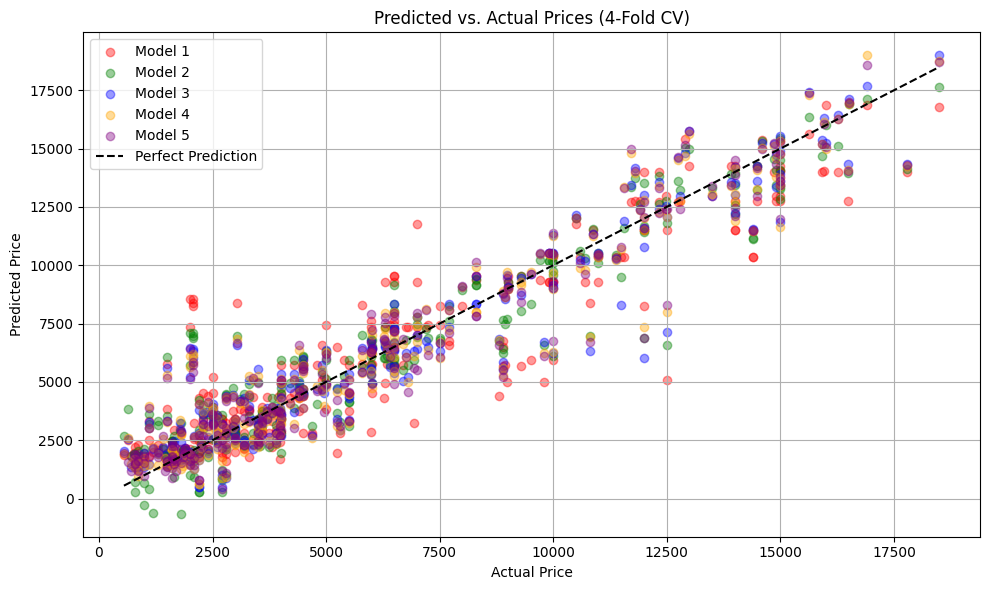

In [93]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)
results = []

for formula in model_equations:
    preds = []
    actuals = []
    for train_idx, test_idx in kf.split(data):
        train_data = data.iloc[train_idx]
        test_data = data.iloc[test_idx]
        model = smf.ols(formula, data=train_data).fit()
        y_pred = model.predict(test_data)
        preds.extend(y_pred)
        actuals.extend(test_data['price'])
    results.append((actuals, preds))

# Plot
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue', 'orange', 'purple']
for i, (actual, pred) in enumerate(results):
    plt.scatter(actual, pred, alpha=0.4, label=f'Model {i+1}', color=colors[i])

plt.plot(
    [data['price'].min(), data['price'].max()],
    [data['price'].min(), data['price'].max()],
    'k--', label='Perfect Prediction'
)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs. Actual Prices (4-Fold CV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Prediction

In [94]:
data = data.loc[
    :,
    [
        "age",
        "agesq",
        "odometer",
        "odometersq",
        "SE",
        "LE",
        "XLE",
        "cond_likenew",
        "cond_excellent",
        "cond_good",
        "dealer",
        "price",
        "cylind6",
    ],
]


In [95]:
data.dtypes


age                 int64
agesq               int64
odometer          float64
odometersq        float64
SE                  int64
LE                  int64
XLE                 int64
cond_likenew        int64
cond_excellent      int64
cond_good           int64
dealer              int64
price               int64
cylind6             int64
dtype: object

In [96]:
new = pd.DataFrame(
    pd.Series(
        {
            "age": 10,
            "agesq": 10**2,
            "odometer": 12,
            "odometersq": 12**2,
            "SE": 0,
            "LE": 1,
            "XLE": 0,
            "cond_likenew": 0,
            "cond_excellent": 1,
            "cond_good": 0,
            "dealer": 0,
            "price": np.nan,
            "cylind6": 0,
        }
    )
).T
new


,age,agesq,odometer,odometersq,SE,LE,XLE,cond_likenew,cond_excellent,cond_good,dealer,price,cylind6
0,10.0,100.0,12.0,144.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0


In [97]:
pd.concat([new, new], ignore_index=True)

,age,agesq,odometer,odometersq,SE,LE,XLE,cond_likenew,cond_excellent,cond_good,dealer,price,cylind6
0,10.0,100.0,12.0,144.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0
1,10.0,100.0,12.0,144.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0


In [98]:
reg1 = regs[0]
reg3 = regs[2]

In [99]:
reg1.resid.describe()


count    2.810000e+02
mean     1.076117e-10
std      1.758313e+03
min     -6.367827e+03
25%     -8.636628e+02
50%     -1.013318e+02
75%      8.936205e+02
max      7.448668e+03
dtype: float64

In [100]:
(reg3.fittedvalues - data.price).describe()


count    2.810000e+02
mean     5.626568e-11
std      1.325029e+03
min     -5.782218e+03
25%     -5.845089e+02
50%      1.056349e+01
75%      6.282881e+02
max      4.245894e+03
dtype: float64

### Table 13.3 Point predictions and interval predictions for a specific car, using models 1 and 3

Use custom function `point_predict_with_conf_int` to extract point and interval prediction for a new datapoint.

In [101]:
help(point_predict_with_conf_int)

NameError: name 'point_predict_with_conf_int' is not defined

In [ ]:
p95 = pd.DataFrame(
    [
        point_predict_with_conf_int(reg1, new, interval_precision=0.95, round_n=0),
        point_predict_with_conf_int(reg3, new, interval_precision=0.95, round_n=0),
    ],
    index=["Model 1", "Model 2"],
).T
p95.loc["Prediction Interval (95%)", :] = p95.loc["Prediction Interval (95%)", :].apply(
    format_confidence_interval
)

In [ ]:
p80 = pd.DataFrame(
    [
        point_predict_with_conf_int(reg1, new, interval_precision=0.8, round_n=0),
        point_predict_with_conf_int(reg3, new, interval_precision=0.8, round_n=0),
    ],
    index=["Model 1", "Model 2"],
).T
p80.loc["Prediction Interval (80%)", :] = p80.loc["Prediction Interval (80%)", :].apply(
    format_confidence_interval
)

In [ ]:
p80.append(p95.loc["Prediction Interval (95%)"])